<center><h1>WRN: Cifar10</h1></center>

## Imports

In [1]:
from __future__ import division,print_function

%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from tqdm import tqdm_notebook as tqdm

import random
import matplotlib.pyplot as plt
import math

import numpy as np
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.autograd import Variable, grad
from torchvision import datasets, transforms
from torch.nn.parameter import Parameter
import pandas as pd
import utils.calculate_log as callog
from utils.wrn import WideResNet

from utils.detector import Detector, gram_margin_loss, new_gram_margin_loss, ScoreDetector
import utils.attacks as attacks

import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.cuda.set_device(2)

## Model definition

In [3]:
torch_model = WideResNet(depth=40, widen_factor=2, num_classes=10)

# torch_model.load(path="checkpoints_score_v1/cifar10_wrn_baseline_epoch_99.pt")
# torch_model.load(path="benchmark_ckpts/cifar10_reg_training_99.pt")
torch_model.load(path="checkpoints_margin_01/cifar10_wrn_baseline_epoch_99.pt")
# torch_model.load(path="benchmark_ckpts/cifar10_style_epoch_99.pt")
# torch_model.load(path="checkpoints_style_fine_tuning/cifar10_wrn_baseline_epoch_2.pt")
torch_model.cuda()
torch_model.params = list(torch_model.parameters())
torch_model.eval()
print("Done")    

Done


## Datasets

<b>In-distribution Datasets</b>

In [4]:
batch_size = 256
# mean = np.array([[125.3/255, 123.0/255, 113.9/255]]).T

# std = np.array([[63.0/255, 62.1/255.0, 66.7/255.0]]).T
# normalize = transforms.Normalize((125.3/255, 123.0/255, 113.9/255), (63.0/255, 62.1/255.0, 66.7/255.0))

normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
        
    ])
transform_test = transforms.Compose([
        transforms.CenterCrop(size=(32, 32)),
        transforms.ToTensor(),
        normalize
    ])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('~/datasets/cifarpy', train=True, download=True,
                   transform=transform_train),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('~/datasets/cifarpy', train=False, transform=transform_test),
    batch_size=batch_size)


detector_data_transform = transforms.Compose([transforms.ToTensor(), normalize])
data_train = list(torch.utils.data.DataLoader(
        datasets.CIFAR10('~/datasets/cifarpy', 
                     train=True, 
                     transform=detector_data_transform, 
                     download=True),
        batch_size=1, shuffle=False))

data_test = list(torch.utils.data.DataLoader(
        datasets.CIFAR10('~/datasets/cifarpy', 
                     train=False, 
                     transform=detector_data_transform, 
                     download=True),
        batch_size=1, shuffle=False))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
def pipeline_batch(bxs):
    pil = transforms.ToPILImage()
    return torch.squeeze(torch.stack([transform_test(pil(bx)) for bx in bxs]), dim=1)

def get_batches(d, batch_size=32):
    bx = []
    by = []
    tens = transforms.ToTensor()
    for idx in range(0,len(d),batch_size):
        bx_batch = torch.squeeze(torch.stack([tens(x[0]) for x in d[idx:idx+batch_size]]),dim=1)
        bx.append(bx_batch)
        by.append(torch.Tensor([x[1] for x in d[idx:idx+batch_size]]).type(torch.LongTensor))
    
    return bx, by

def advs_p(p, bxs, bys, nrof_batches=None):
    if nrof_batches is None:
        nrof_batches = len(bxs)
        
    advs = []
    for i in tqdm(range(len(bxs))):
        if i >= nrof_batches:
            break
        
        _, feats_reg = torch_model.gram_forward((bxs[i]*2 - 1).cuda())
        advs_batch = p(torch_model, bxs[i].cuda(), bys[i].cuda())

        advs.append(advs_batch)

    torch.cuda.empty_cache()
    
    return advs

def adversarial_acc(advs, bys):
    torch_model.eval()
    correct = 0
    total = 0

    for i in range(len(advs)):
        pipelined = pipeline_batch(advs[i].cpu())

        x = pipelined.cuda()
        y = bys[i].numpy()

        correct += (y==np.argmax(torch_model(x).detach().cpu().numpy(),axis=1)).sum()
        total += y.shape[0]


    print("Adversarial Test Accuracy: ", correct/total)
    
def ds_grouped(bxs, bys):
    ds = []
    for i in range(len(bxs)):
        pipelined = pipeline_batch(bxs[i].cpu())
        for j in range(len(bxs[i])):
            ds.append((pipelined[j], bys[i][j]))
    return ds

def adversarial_scores(detector, advs_batches, pbar = lambda x, total=None: x):
    auroc = []
    for batch in pbar(advs_batches):
        auroc.append(detector.compute_ood_deviations_batch(batch*2 - 1)["AUROC"])
    
    return np.mean(auroc)

def model_accuracy():
    torch_model.eval()
    correct = 0
    total = 0
    for x,y in test_loader:
        x = x.cuda()
        y = y.numpy()
        correct += (y==np.argmax(torch_model(x).detach().cpu().numpy(),axis=1)).sum()
        total += y.shape[0]
        
    return correct/total

<center><h1> Results </h1></center>

In [6]:
model_accuracy()

0.7991

In [7]:
detector = Detector(torch_model, data_train, data_test, 512, pbar=None)

In [27]:
adversary = attacks.PGD(epsilon=8./255, num_steps=10, step_size=2./255).cuda()

In [28]:
cifar10 = list(datasets.CIFAR10('~/datasets/cifarpy', train=False))

print("Calculating L_Inf")
xs, ys = get_batches(cifar10, batch_size=128)
# pinf = PGD()
pinf = adversary
# pinf = PGD_margin().cuda()
advs_inf = advs_p(pinf, xs, ys)

adversarial_acc(advs_inf, ys)

adversarial_scores(detector, advs_inf, pbar=tqdm)

Calculating L_Inf



Adversarial Test Accuracy:  0.0


0.9675182555379747

In [8]:
cifar10 = list(datasets.CIFAR10('~/datasets/cifarpy', train=False))
random.shuffle(cifar10)
xs, ys = get_batches(cifar10, batch_size=64)

dt = ScoreDetector()

In [9]:
def gram_matrix(layer):
    b, ch, h, w = layer.size()
    features = layer.view(b, ch, w * h)
    gram = torch.matmul(features, features.transpose(1, 2))
    
    return gram /(ch * h * w)

def style_loss(lhs, rhs):
    loss = 0.0
    for i in range(len(lhs)):
        loss += (gram_matrix(lhs[i]) - gram_matrix(rhs[i])).pow(2).sum()
    
    return loss.mean()

def calc_vals(x, y):
    x, y = x.cuda(), y.cuda()
    
    logits_reg, feats_reg = torch_model.gram_forward(x*2 - 1)
    
#     adv_x = attacker_smart(torch_model, x, y, feats_reg)
    adv_x = attacker_smart(torch_model, x, y)
#     adv_x = attacker_naive(torch_model, x, y)
    logits_adv, feats_adv = torch_model.gram_forward(adv_x * 2 - 1)
    
    x, y = x.cpu(), y.cpu()
    adv_x = adv_x.cpu()
    logits_adv = logits_adv.cpu()
    
#     print(score(feats_adv) - score(feats_reg))
    
    acc = (y==torch.max(logits_adv,dim=1)[1]).numpy().mean()
    auroc, auroc_failed = detector.compute_auroc_advs(logits_adv.detach(), feats_adv, y)
    
    return feats_reg, feats_adv, auroc, auroc_failed, acc

In [10]:
def process_batch(x, y, margin=20, smart=True):
    feats_reg, feats_adv, auroc, auroc_failed, acc = calc_vals(x, y)
    
#     return style_loss(feats_reg, feats_adv).cpu()
    return auroc, auroc_failed, acc, feats_reg, feats_adv

In [12]:
with torch.no_grad():
#     attacker_smart = attacks.PGD_Gram(detector, 
#                               num_steps=10, 
#                               epsilon=8./255, 
#                               step_size=2.0/255, 
#                               verbose=True)
    
#     attacker_smart = attacks.PGD_margin(margin = 10,
#                                 epsilon=8./255, 
#                                 num_steps=10, 
#                                 step_size=2/255, 
#                                 verbose=True)
#     margin = 10
#     attacker_smart = PGD_margin(epsilon=8./255, 
#                                    num_steps=0, 
#                                    step_size=2./255, 
#                                    margin=margin,
#                                    margin_scale=1,
#                                 verbose=True)

    attacker_smart = attacks.PGD_score(score_scale=1000,
                                    epsilon=8./255, 
                                   num_steps=10, 
                                   step_size=2./255, 
                                    verbose=True)

    attacker_naive = attacks.PGD(epsilon=8./255, num_steps=10, step_size=2./255)
    
    auroc, auroc_failed, acc = [], [], []
    for i, x in tqdm(enumerate(xs), total=len(xs)):
        a, a_f, accuracy, feats_reg, feats_adv = process_batch(x, ys[i])
        auroc.append(a)
        auroc_failed.append(a_f)
        acc.append(accuracy)
        
#         labels = np.array([0] * len(feats_reg[0]) + [1] * len(feats_adv[0]))
#         scores = np.concatenate((score(feats_reg, False).cpu(), score(feats_adv, False).cpu()))

#         fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
#         auc = metrics.auc(fpr, tpr)

        auc = dt.calc_auroc(feats_reg, feats_adv)
        print(auc)
        
        if i >= 0:
            break

Step: 0, Cent: 1.136912226676941, Gram: tensor([9.8307e-10], device='cuda:2'), Total Loss: tensor([1.1369], device='cuda:2')
Step: 1, Cent: 4.336390495300293, Gram: tensor([0.0071], device='cuda:2'), Total Loss: tensor([-2.7547], device='cuda:2')
Step: 2, Cent: 3.5634055137634277, Gram: tensor([8.9993e-06], device='cuda:2'), Total Loss: tensor([3.5544], device='cuda:2')
Step: 3, Cent: 8.377714157104492, Gram: tensor([0.0081], device='cuda:2'), Total Loss: tensor([0.2438], device='cuda:2')
Step: 4, Cent: 5.021505355834961, Gram: tensor([8.9888e-07], device='cuda:2'), Total Loss: tensor([5.0206], device='cuda:2')
Step: 5, Cent: 9.927082061767578, Gram: tensor([0.0063], device='cuda:2'), Total Loss: tensor([3.5932], device='cuda:2')
Step: 6, Cent: 6.349969387054443, Gram: tensor([1.7116e-06], device='cuda:2'), Total Loss: tensor([6.3483], device='cuda:2')
Step: 7, Cent: 11.239173889160156, Gram: tensor([0.0054], device='cuda:2'), Total Loss: tensor([5.8508], device='cuda:2')
Step: 8, Cent

In [19]:
np.array(auroc).mean(), np.array(auroc_failed).mean(), np.array(acc).mean()

(0.9993509090909091, 0.9996, 0.140625)

In [9]:
def G_p(temp):
    normalizer = torch.prod(torch.tensor(temp.shape[1:]))
    temp = temp.reshape(temp.shape[0],temp.shape[1],-1)
    temp = (torch.matmul(temp,temp.transpose(dim0=2,dim1=1))).reshape(temp.shape[0],-1).sum(dim=1)
    
    return temp/normalizer

def get_deviations(feat_list, mean=True):
    batch_deviations = []
    for L,feat_L in enumerate(feat_list):
        dev = 0

        g_p = G_p(feat_L)
        g_p = g_p
        dev = g_p
        
        if mean:   
            batch_deviations.append(dev.mean())
        else:
            batch_deviations.append(dev)
        
    return batch_deviations

def score(feats, mean=True):
    devs = get_deviations(feats, mean)
    
    return torch.stack(devs).mean(dim=0).reshape(-1,)

In [11]:
class PGD_score(nn.Module):
    def __init__(self, epsilon=8./255, num_steps=10, step_size=2./255, score_scale = 100, verbose=False, detector=ScoreDetector()):
        super().__init__()
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.step_size = step_size
        self.verbose = verbose
        self.detector = detector
        self.score_scale = score_scale

    def forward(self, model, bx, by):
        """
        :param model: the classifier's forward method
        :param bx: batch of images
        :param by: true labels
        :return: perturbed batch of images
        """
        adv_bx = bx.detach()
        adv_bx += torch.zeros_like(adv_bx).uniform_(-self.epsilon, self.epsilon)
        
        for i in range(self.num_steps):
            adv_bx.requires_grad_()
            
            with torch.enable_grad():
                logits, feats_adv = model.gram_forward(adv_bx * 2 - 1)
                gram_score = F.softplus(self.detector.score(feats_adv) - .125, beta=100)
                cent_loss = F.cross_entropy(logits, by, reduction='mean').cuda()
                
                loss = cent_loss - self.score_scale * gram_score

                if self.verbose:
                    print("Step: {}, Cent: {}, Gram: {}, Total Loss: {}".format(i, cent_loss.data, gram_score.data, loss.data))
            grad = torch.autograd.grad(loss, adv_bx, only_inputs=True)[0]
            adv_bx = adv_bx.detach() + self.step_size * torch.sign(grad.detach())
            adv_bx = torch.min(torch.max(adv_bx, bx - self.epsilon), bx + self.epsilon).clamp(0, 1)
            
        return adv_bx

In [293]:
with torch.no_grad():
    _, f = torch_model.gram_forward((xs[0].cuda() + torch.zeros_like(xs[0].cuda()).uniform_(-8/255, 8/255)).cuda() * 2 - 1)

In [290]:
f = cpu(f)

In [309]:
score(feats_reg) - score(feats_adv)

tensor([-188.3312,  -33.0728, -166.5293, -265.6161, -301.9734, -202.8130,
        -199.3248, -244.1910, -208.7040, -455.5402, -157.3834, -260.6914,
        -126.7905, -200.8347, -286.7367, -125.9502,  -28.4041, -436.9200,
        -415.3741, -173.4412, -260.6412, -419.4022, -486.2969, -421.5978,
         -29.6512, -249.9574, -271.2870,  -52.1218,  -76.0488, -190.6174,
        -188.3594, -133.2872, -201.9915, -112.3499, -345.7244, -273.1459,
        -208.6133,  -33.9136, -414.5116, -172.8745, -133.9536, -440.6256,
        -447.5640, -307.6598, -100.0914, -449.1730, -197.7748, -381.5724,
        -387.4440, -225.7218, -318.5923, -119.4291, -407.4978, -117.7936,
        -205.7057, -479.7089, -102.3668, -195.5171, -379.7212, -168.8208,
        -391.9598, -384.7391, -262.3494, -195.6018])

In [307]:
labels = np.array([0] * len(feats_reg[0]) + [1] * len(feats_adv[0]))
scores = np.concatenate((score(feats_reg), score(f)))

fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
auc = metrics.auc(fpr, tpr)

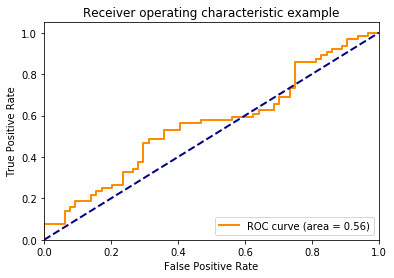

In [308]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Gram Deviation Loss Detector:

- Successful Adversaries (AUROC): `0.7030564379258805`
- Failed Adversaries (AUROC): `0.5845281134654501`
- Percent of adversaries failed: `0.08449074074074074`

Gram Margin Loss:

- Successful Adversaries (AUROC): `0.5029065593498265`
- Failed Adversaries (AUROC): `0.4706757174491286`
- Percent of adversaries failed: `0.3460648148148148`

Gram Margin Loss (Class Variant):

- Successful Adversaries (AUROC): `0.5140263697307398`
- Failed Adversaries (AUROC): `0.5171176091325425`
- Percent of adversaries failed: `0.35908564814814814`

Style Loss:

- Successful Adversaries (AUROC): `~0.96`
- Failed Adversaries (AUROC): `~0.50`
- Percent of adversaries failed: `~0.75`

In [9]:
def G_p(temp):
    temp = temp.reshape(temp.shape[0],temp.shape[1],-1)
    temp = ((torch.matmul(temp,temp.transpose(dim0=2,dim1=1)))).sum(dim=2)
    return temp.reshape(temp.shape[0],-1)

class PGD_margin(nn.Module):
    def __init__(self, epsilon=8./255, num_steps=10, step_size=2./255, margin = 20, margin_scale=1.0, verbose=False):
        super().__init__()
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.step_size = step_size
        self.verbose = verbose
        self.margin = margin
        self.margin_scale = margin_scale

    def forward(self, model, bx, by, feats_reg):
        """
        :param model: the classifier's forward method
        :param bx: batch of images
        :param by: true labels
        :return: perturbed batch of images
        """
        adv_bx = bx.detach()
        adv_bx += torch.zeros_like(adv_bx).uniform_(-self.epsilon, self.epsilon)
        
        for i in range(self.num_steps):
            adv_bx.requires_grad_()
            
            with torch.enable_grad():
                logits, feats_adv = model.gram_forward(adv_bx * 2 - 1)
                gram_margin = self.margin_scale * gram_margin_loss(feats_reg, feats_adv, self.margin).cuda()
                cent_loss = 0.0 * F.cross_entropy(logits, by, reduction='mean').cuda()
                
                loss = cent_loss + gram_margin
                
                if self.verbose:
                    print("Step: {}, Cent: {}, Margin Loss: {}, Total Loss: {}".format(i, cent_loss, gram_margin, loss))
            grad = torch.autograd.grad(loss, adv_bx, only_inputs=True)[0]
            adv_bx = adv_bx.detach() + self.step_size * torch.sign(grad.detach())
            adv_bx = torch.min(torch.max(adv_bx, bx - self.epsilon), bx + self.epsilon).clamp(0, 1)
            
        return adv_bx

In [8]:
powers=[1]
def cpu(ob):
    for i in range(len(ob)):
        for j in range(len(ob[i])):
            ob[i][j] = ob[i][j].cpu()
    return ob
    
def cuda(ob):
    for i in range(len(ob)):
        for j in range(len(ob[i])):
            ob[i][j] = ob[i][j].cuda()
    return ob
def calc_gram_dev_target():
    return detector.all_test_deviations.mean(axis=0).sum() 

def G_p_gpu(temp):
    temp = temp.reshape(temp.shape[0],temp.shape[1],-1)
    temp = ((torch.matmul(temp,temp.transpose(dim0=2,dim1=1)))).sum(dim=2)
    return temp.reshape(temp.shape[0],-1)

# def G_p_gpu(ob, p):
#     temp = ob
    
#     temp = temp**p
#     temp = temp.reshape(temp.shape[0],temp.shape[1],-1)
#     temp = ((torch.matmul(temp,temp.transpose(dim0=2,dim1=1)))).sum(dim=2) 
#     temp = (temp.sign()*torch.abs(temp)**(1/p)).reshape(temp.shape[0],-1)
    
#     return temp

class PGD_Gram(nn.Module):
    def __init__(self, epsilon=8/255, num_steps=10, step_size=2/255, grad_sign=True, 
                         mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], nrof_classes=10, gram_target = 247, verbose=True):
        super().__init__()
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.step_size = step_size
        self.grad_sign = grad_sign
        
        if mean is None:
            self.mean = torch.FloatTensor([0.4914, 0.4822, 0.4465]).view(1,3,1,1).cuda()
        else:
            self.mean = torch.FloatTensor(mean).view(1,3,1,1).cuda()
        if std is None:
            self.std = torch.FloatTensor([0.2023, 0.1994, 0.2010]).view(1,3,1,1).cuda()
        else:
            self.std = torch.FloatTensor(std).view(1,3,1,1).cuda()
            
        self.mns = [cuda(detector.mins[i]) for i in range(nrof_classes)]
        self.mxs = [cuda(detector.maxs[i]) for i in range(nrof_classes)]
        self.gram_target = gram_target * 0.85
        self.verbose = verbose
            
    def get_deviation(self, feat_list, idx, mins, maxs, power=powers):
        batch_deviations = []
        for L,feat_L in enumerate(feat_list):
            dev = 0
            
            g_p = G_p_gpu(feat_L)[idx]
                
            dev +=  (F.relu(mins[L][0]-g_p)/torch.abs(mins[L][0]+10**-6)).sum(dim=1,keepdim=True)
            dev +=  (F.relu(g_p-maxs[L][0])/torch.abs(maxs[L][0]+10**-6)).sum(dim=1,keepdim=True)
                
            batch_deviations.append(dev)
                
        return batch_deviations
        
    def gram_loss(self, logits, feats):
        confs = F.softmax(logits, dim=1)
        _, indices = torch.max(confs, 1)
        
        loss = 0
        for i in range(10):
            idxs = indices == i

            if idxs.sum() == 0:
                continue
            
            batch_dev = self.get_deviation(feats, idxs, mins=self.mns[i], maxs=self.mxs[i])
            batch_dev = torch.squeeze(torch.stack(batch_dev, dim=1))
            
            loss += batch_dev.sum()
                            
        return F.relu((loss/logits.shape[0]) - self.gram_target)
    
    def forward(self, model, bx, by):
        """
        :param model: the classifier's forward method
        :param bx: batch of images
        :param by: true labels
        :return: perturbed batch of images
        """
        model.eval()
        
        adv_bx = bx.detach()
        adv_bx += torch.zeros_like(adv_bx).uniform_(-self.epsilon, self.epsilon)

        for i in range(self.num_steps):
            adv_bx.requires_grad_()
            with torch.enable_grad():
                logits, feats = model.gram_forward((adv_bx - self.mean)/self.std)
                
                cent_loss = F.cross_entropy(logits, by, reduction='mean')
                gram_loss =  detector.gram_loss(logits, feats)
                
                loss = cent_loss - gram_loss
                                
            if self.verbose:
                print("Step: {}, Cent: {}, Gram: {}, Total Loss: {}".format(i, cent_loss, gram_loss, loss))
            
            grad = torch.autograd.grad(loss, adv_bx, only_inputs=True)[0]
            adv_bx = adv_bx.detach() + self.step_size * torch.sign(grad.detach())
            adv_bx = torch.min(torch.max(adv_bx, bx - self.epsilon), bx + self.epsilon).clamp(0, 1)

        return adv_bx